In [1]:
# baseball-regression.ipynb
# Alexis Perumal, Venkat Pinnika, Young You, 1/8/2020
#
# Objective:
# . Build a predictor for the winner of baseball games (visitor or home)
#   with > 50% prediction accuracy, with statistical accuracy.
# . Analysis will be done by season, looking at all the regular season
#   games of a given year with each days' game predicted based on info
#   up to, but not including that day.
#
# Strategy:
# . Build a dataframe of games (rows) and factors to build a regression
#   model for visiting net points, and by extension, predict the winner
#   of each game (visitor or home).
# . Explore candidate factors with regression analysis (T-stat, F-stat,
#   p-value), build and optimize a simple LSR model using a training set
#   through the 2017 Season.
# . Plot the results.
# . Ultimately, apply the model to the 2018, then 2019 seasons.
#
# 1/9/20 - Updating to add pitcher-based prediction

In [2]:
# Modules
import os
import csv
import pprint
import pandas as pd
import glob
import pprint
import datetime
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
!pwd

/Users/aperumal/OneDrive/Personal/UCSD_Data_Science_Bootcamp/Homework/2019-12-18_Proj1_Baseball-Predictor/baseball-predictor/alexis-regression


In [3]:
# Support functions
def date_str(date: int):
    s = str(date)
    return f"{s[0:4]}-{s[4:6]}-{s[6:]}"


# Passed the gamedays series (YYYYMMDD) and season (year) return with the first
# and last game dates.
def date_range(gamedays, season):
    # Converts 'YYYY' string to an integer start date, YYYY0101 and end date YYYY1231
    def season_to_date(season): 
#         return (int(season)*10000 + 101, int(season)*10000+1231)
        # Hack to shorten the season for dev purposes (faster analysis)
        return (int(season)*10000 + 101, int(season)*10000+430)
    
    first_of_year, last_of_year = season_to_date(season)
    season_gamedays = gamedays.loc[((gamedays >= first_of_year) &
                                    (gamedays <= last_of_year))]
    return (season_gamedays.iloc[0], season_gamedays.iloc[-1])
    

# returns new game date offset by n. Passed in the gamedays series.
def gamedays_offset(gamedays, base_date, n): 
    if base_date not in gamedays.values:
        raise ValueError(f"{base_date}, not in the the gamedays series.")
    base_date_index = gamedays[gamedays==base_date].index[0]
    if ((n + base_date_index) < 0) or n + base_date_index >= len(gamedays):
        raise ValueError(f"Attempting to calculate a game date outside the dataset.")
        return(0)  # Out of range
    else:
        new_index = base_date_index + n
        return gamedays.iloc[new_index]
    
def derive_metrics(results_df):
    num_games = len(results_df)
    num_correct = results_df['Prediction Correct?'].values.sum()
    percent_correct = num_correct/num_games*100.
    return (num_games, num_correct, percent_correct)

In [4]:
def read_source_data():
    def reader(f):
        df = pd.read_csv(f, index_col=False, header=None)  
        df.columns = [("Col_"+str(i)) for i in range(1,df.shape[1]+1)]       
        return df

    files = glob.glob("../datasets/Final_Data_Files/GL*.csv")
    files.sort()
    df = pd.concat([reader(f) for f in files])
    old_df_len = len(df)
    
    # Insert column headers
    df = df.rename(columns={'Col_1':'Date',
                            'Col_4':'Visiting Team',
                            'Col_5':'Visiting League',
                            'Col_7':'Home Team',
                            'Col_8':'Home League',
                            'Col_10':'Visiting Score',
                            'Col_11':'Home Score',
                            'Col_102':'V Start Pitcher ID',
                            'Col_104':'H Start Pitcher ID'
                           }).reset_index()
    df = df[['Date', 'Visiting Team', 'Visiting League', 'Home Team', 'Home League',
            'Visiting Score','Home Score', 'V Start Pitcher ID','H Start Pitcher ID']]
    
    df = df.replace('FLO','MIA') # After the 2011 season, the Florida Marlins
                                 # rebranded themselves the Miami Marlins. This
                                 # search and replace makes the two the same.
    
    # Drop all rows with missing information
    # print(df.head())
    df = df.dropna(how='any')
    if len(df) < old_df_len:
        print(f"Dropped {old_df_len-len(df)} rows due to missing data.")
    
    # Create new columns we'll need. 
#     df['Key'] = df['Date'].astype(str) + df['Visiting Team']
    df['Home Winner'] = df['Home Score'] > df['Visiting Score']
    df['V NetRuns'] = df['Visiting Score'] - df['Home Score']
    df['H NetRuns'] = - df['V NetRuns']
    
    #     print(df.shape)
    print(f"Dataset loaded with {df.shape[0]} games, ", end='')
    print(f"{df.shape[1]} columns, {date_str(df.iloc[0, 0])} - ", end='')
    print(f"{date_str(df.iloc[-1,0])}")
    return df

# read_source_data()

In [5]:
# Given a games df with predictions and prediction resuls by game already captured,
# generate an outcomes dataframe with stats by season.
def append_outcomes(outcomes_df, g, ra_d): # g is the games dataframe with predictions
                                             # d is the dictionary with run attributes to log
    # 1. Capture results spanning the entire dataset (all seasons)
    num_games = len(g)
    num_correct = g['Prediction Correct?'].values.sum()
    home_win_percent = g['Home Winner'].values.sum() / num_games * 100
    home_predict_percent = g['Home Wins?'].values.sum() / num_games * 100
    percent_correct = num_correct/num_games*100.
    
    new_row = pd.Series({'Predictor':'Net or Raw Points (see Net)',
                         'Season':0, # Indicates all seasons in the dataset.
                         'Lookback':ra_d['Lookback'],
                         'Net':ra_d['Net'],
                         'Num Games':num_games,
                         'Home Win %':home_win_percent,
                         'Home Predict %':home_predict_percent,
                         'Num Correct':num_correct,
                         '% Correct':percent_correct,
                         'Comment':('All Seasons' + ra_d['Comment'])})
    outcomes_df = outcomes_df.append(new_row, ignore_index=True)
    
    # 2. Caculate individual seasons represented in the dataset
    seasons = g['Date'].transform(lambda x: int(x/10000)).unique().tolist()
#     pprint.pprint(seasons)
    
    for season in seasons:
        start_date = int(season)*10000 + 101  # YYYYMMDD, Jan 01 of the Year
        end_date = int(season)*10000 + 1231   # YYYYMMDD, DEC 31 of the Year
        season_df = g.loc[((g['Date']>= start_date) &(g['Date']<= end_date)), :]
        
        num_games = len(season_df)
        num_correct = season_df['Prediction Correct?'].values.sum()
        home_win_percent = season_df['Home Winner'].values.sum() / num_games * 100
        home_predict_percent = season_df['Home Wins?'].values.sum() / num_games * 100
        percent_correct = num_correct/num_games*100.
        
        new_row = pd.Series({'Predictor':ra_d['Predictor'],
                     'Season':season,
                     'Lookback':ra_d['Lookback'],
                     'Net':ra_d['Net'],
                     'Num Games':num_games,
                     'Home Win %':home_win_percent,
                     'Home Predict %':home_predict_percent,
                     'Num Correct':num_correct,
                     '% Correct':percent_correct,
                     'Comment':('All Seasons' + ra_d['Comment'])})
        
        outcomes_df = outcomes_df.append(new_row, ignore_index=True)
        
    return outcomes_df

In [24]:
# Predict games based on net points or raw points over a lookback window, visitor vs home.
def net_point_predictor(outcomes_df, lookback_n, prior_exclude=0, net=True):
    # Let's get started. Read the dataset.
    games_df = read_source_data()
    
    num_games = len(games_df)
    home_wins = games_df['Home Winner'].sum()
    home_wins_percent = home_wins / num_games * 100.
    print(f'Baseline results: {num_games} games, {home_wins} home wins = {round(home_wins_percent, 2)}%')
    
    games_df.index.set_names('games_idx', inplace=True)
    
    # Calculate rolling average of net points excluding the current row (shift=prior_exclude+1)
    if net:
        games_df = games_df.sort_values(by = ['Visiting Team','games_idx'])
        games_df['V NP Avg'] = games_df.groupby('Visiting Team')['V NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())

        games_df = games_df.sort_values(by = ['Home Team','games_idx'])
        games_df['H NP Avg'] = games_df.groupby('Home Team')['H NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
    else:
        games_df = games_df.sort_values(by = ['Visiting Team','games_idx'])
        games_df['V NP Avg'] = games_df.groupby('Visiting Team')['Visiting Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())

        games_df = games_df.sort_values(by = ['Home Team','games_idx'])
        games_df['H NP Avg'] = games_df.groupby('Home Team')['Home Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
       
    games_df = games_df.sort_index()
    
    
    num_na = games_df['V NP Avg'].isna().sum()
    print(f'num_na = {num_na}, these will be dropped.')

    print(f"  # of games before dropping lookback window: {len(games_df)}")
    # games_df.to_csv("output/result_before_dropna.csv")
    games_df = games_df.dropna(how='any')
    print(f"  # of games after dropping lookback window: {len(games_df)}")

    games_df['Home Wins?'] = games_df['H NP Avg'] >= games_df['V NP Avg']
    games_df['Prediction Correct?'] = games_df['Home Wins?'] == games_df['Home Winner']
    
    # Setup run attributes so they can be included in the outcomes_df generated.
    run_attributes = {'Predictor':'Points', 'Lookback':n, 'Net':False, 'Comment':''}
    
    return append_outcomes(outcomes_df, games_df, run_attributes)


In [25]:
# Predict games based on pitcher performance over a lookback window, visitor vs home.
def pitcher_predictor(outcomes_df, lookback_n):
    # Let's get started. Read the dataset.
    g = read_source_data()
    
    num_games = len(g)
    home_wins = g['Home Winner'].sum()
    home_wins_percent = home_wins / num_games * 100.
    print(f'Baseline results: {num_games} games, {home_wins} home wins = {round(home_wins_percent, 2)}%')
    
    g.index.set_names('games_idx', inplace=True)
    
    
    # Calculate rolling average of net points excluding the current row (shift=prior_exclude+1)
    g = g.sort_values(by = ['V Start Pitcher ID', 'games_idx'])
    g['V Runs Allowed'] = g.groupby('V Start Pitcher ID')['Home Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
#     print(g.head())

    g = g.sort_values(by = ['H Start Pitcher ID', 'games_idx'])
    g['H Runs Allowed'] = g.groupby('H Start Pitcher ID')['Visiting Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
#     print(g.head())
    
    g = g.sort_index()

    # For na's due to a lack of pitcher data, we should substitute data, not remove.
    # print(f"  # of games before dropping lookback window: {len(g)}")
    num_na = g['V Runs Allowed'].isna().sum()
    print(f'num_na = {num_na}')
    # g = g.dropna(how='any')
    g = g.fillna(999)

    g['Home Wins?'] = g['H Runs Allowed'] <= g['V Runs Allowed']
    g['Prediction Correct?'] = g['Home Wins?'] == g['Home Winner']
    
    # Setup run attributes so they can be included in the outcomes_df generated.
    run_attributes = {'Predictor':'Pitcher', 'Lookback':n, 'Net':False, 'Comment':''}
    
#     base_path = str(datetime.datetime.now()).replace(':', '-').replace(' ', '_')
#     data_output_path = "debug-pitcher-output/" + base_path + "_output.csv"
#     g.to_csv(path_or_buf=data_output_path)
    
    return append_outcomes(outcomes_df, g, run_attributes)


In [26]:
# Top level (main) code, read in the dataset, add the columns we care about.
outcomes_df = pd.DataFrame(columns=['Season', 'Lookback', 'Net', 'Num Games',
                                  'Num Correct', '% Correct', 'Comment'])
# outcomes2_df = pd.DataFrame(columns=['Season', 'Lookback', 'Net', 'Num Games',
#                                   'Num Correct', '% Correct', 'Comment'])

# for n in [1, 2, 5, 10, 15, 20, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500]:
# for n in [50, 60, 70, 80, 90, 100]:
# for n in [5, 10, 25, 50, 75, 100, 150, 200]:
for n in [1, 2, 5, 10, 20, 50, 100]:
# for n in [1, 2, 5, 10, 20, 30, 40, 60, 80, 100]:
    prior_exclude = 0

    if True: # True is NPP predictor, False is pitcher
        net=False
        outcomes_df = net_point_predictor(outcomes_df, n, prior_exclude, net=net)
        print(f"  Net Point Predictor, lookback={n}, prior exclude={prior_exclude}, net={net} done.")
        print("")
    else:
        outcomes_df = pitcher_predictor(outcomes_df, n)
        print("")

outcomes_df


Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
Baseline results: 19437 games, 10438 home wins = 53.7%
num_na = 30, these will be dropped.
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 19399
  Net Point Predictor, lookback=1, prior exclude=0, net=False done.

Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
Baseline results: 19437 games, 10438 home wins = 53.7%
num_na = 60, these will be dropped.
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 19361
  Net Point Predictor, lookback=2, prior exclude=0, net=False done.

Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
Baseline results: 19437 games, 10438 home wins = 53.7%
num_na = 150, these will be dropped.
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 19275
  Net Point Predictor, lookback=5, prior exclude=0, net=False done.

Dat

,Season,Lookback,Net,Num Games,Num Correct,% Correct,Comment,Home Predict %,Home Win %,Predictor
0,0,1,False,19399,9940,51.239755,All Seasons,54.848188,53.688334,Net or Raw Points (see Net)
1,2010,1,False,2392,1238,51.755853,All Seasons,56.312709,55.811037,Points
2,2011,1,False,2429,1227,50.514615,All Seasons,54.013998,52.531906,Points
3,2012,1,False,2430,1281,52.716049,All Seasons,54.320988,53.292181,Points
4,2013,1,False,2431,1246,51.254628,All Seasons,54.380913,53.763883,Points
...,...,...,...,...,...,...,...,...,...,...
57,2013,100,False,2431,1302,53.558206,All Seasons,58.823529,53.763883,Points
58,2014,100,False,2430,1278,52.592593,All Seasons,50.617284,53.004115,Points
59,2015,100,False,2429,1243,51.173322,All Seasons,57.966241,54.178674,Points
60,2016,100,False,2428,1292,53.212521,All Seasons,52.677100,53.006590,Points


In [27]:
seasons = outcomes_df['Season'].unique().tolist()
seasons

[0, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [28]:
season_gb = outcomes_df.groupby('Season')
type(season_gb)
y = season_gb.get_group(0)['% Correct']
print(y)
x = season_gb.get_group(0)['Lookback']
print(x)

0     51.239755
9     51.629565
18    51.315175
27    51.562909
36    51.855593
45    52.418994
54    52.771849
Name: % Correct, dtype: float64
0       1
9       2
18      5
27     10
36     20
45     50
54    100
Name: Lookback, dtype: object


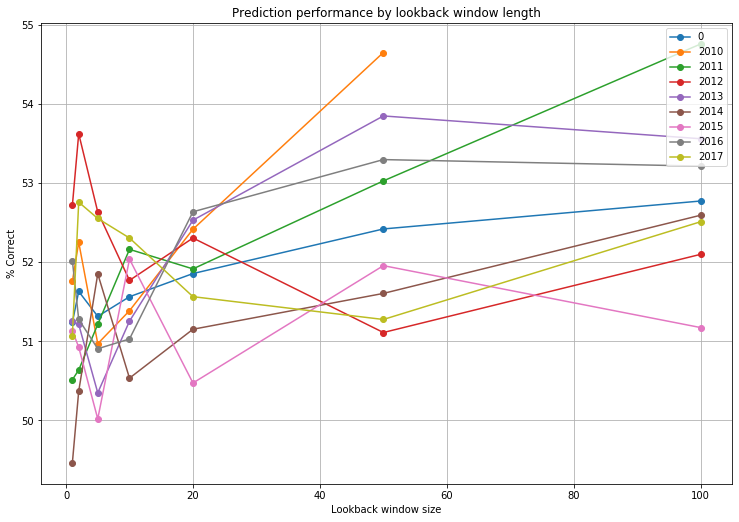

In [29]:
fig = plt.figure(figsize=(12,8))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.set_title('Prediction performance by lookback window length')
axes.set_xlabel('Lookback window size')
axes.set_ylabel('% Correct')

# Todo: Need to represent the predictor type in the plot text!

# for season in range(2012, 2018):
for season in outcomes_df['Season'].unique().tolist():
    x = season_gb.get_group(season)['Lookback']
    y = season_gb.get_group(season)['% Correct']
    axes.plot(x, y, label=str(season), marker='o')
    
axes.legend(loc='upper right')
axes.grid()
plt.show()

In [30]:
if True:
    base_path = str(datetime.datetime.now()).replace(':', '-').replace(' ', '_')
    data_output_path = "output/" + base_path + "_output.csv"
    outcomes_df.to_csv(path_or_buf=data_output_path)
    plot_output_path = "plot/" + base_path + "_plot.png"
    fig.savefig(plot_output_path)

In [ ]:
# Regression Analysis
def net_points_regression(lookback_n, prior_exclude=0):
    # Let's get started. Read the dataset.
    games_df = read_source_data()
    
    # Caculate seasons represented in the dataset
    seasons = games_df['Date'].transform(lambda x: int(x/10000)).unique().tolist()
    pprint.pprint(seasons)
    

    # Calculate rolling average of net points excluding the current row (shift=prior_exclude+1)
    games_df = games_df.sort_values(by = ['Visiting Team','Date'])
    games_df['V NP Avg'] = games_df.groupby('Visiting Team')['V NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
    games_df['V P Avg'] = games_df.groupby('Visiting Team')['Visiting Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
    
    games_df = games_df.sort_values(by = ['Home Team','Date'])
    games_df['H NP Avg'] = games_df.groupby('Home Team')['H NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())

    games_df = games_df.sort_index()

    print(f"  # of games before dropping lookback window: {len(games_df)}")
    games_df.to_csv("output/result_before_dropna.csv")
    games_df = games_df.dropna(how='any')
    print(f"  # of games after dropping lookback window: {len(games_df)}")

    
    # The data table is built, now let's do the regression
    x = games_df['V NP Avg']
#     y = games_df['V NetRuns']
    y = games_df['V P Avg']
    slope, y_int, r, p, se = stats.linregress(x, y)
    
    print(f"slope: {slope}, int: {y_int}, r: {r}, r2: {r**2}, p: {p}, std error of the mean: {se}")
    
    
    
#     games_df['Pred V NP']
    
    
#     games_df['Home Wins?'] = games_df['H NP Avg'] >= games_df['V NP Avg']
#     games_df['Prediction Correct?'] = games_df['Home Wins?'] == games_df['Home Winner']

# This calls the above code
if False:
    net_points_regression(80)

In [ ]:
# From Venkat, on pitchers
# v_pitchers = game_day_df2['V Start Pitcher ID'].to_list()
# v_pitcher_net_score = []
# for pitcher in v_pitchers:
#     v_pitcher_net_score.append(train_df.loc[(train_df['V Start Pitcher ID']==pitcher),:]['Home Score'].mean())
# game_day_df2['V Avg Pitcher Runs given'] = v_pitcher_net_score
# h_pitchers = game_day_df2['H Start Pitcher ID'].to_list()
# h_pitcher_net_score = []
# for pitcher in h_pitchers:
#     h_pitcher_net_score.append(train_df.loc[(train_df['H Start Pitcher ID']==pitcher),:]['Visiting Score'].mean())
# game_day_df2['H Avg Pitcher Runs given'] = h_pitcher_net_score
# game_day_df2['Predict Home Pitcher Wins?'] = game_day_df2['H Avg Pitcher Runs given'] < game_day_df2['V Avg Pitcher Runs given']
# game_day_df2